In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import warnings
warnings.filterwarnings('ignore')
np.random.seed(42)
tf.random.set_seed(42)
print("Setup complete!")

Setup complete!


Generated TRAINING trajectory: 10000 points, initial=[1.0, 1.0, 1.0]
Generated TEST trajectory: 10000 points, initial=[5.0, 10.0, 15.0]

Training samples: 3000
Validation samples: 7000
Test samples: 10000 (from separate trajectory)
Training sequences: 2950, Val: 6950, Test: 9950

[1/3] Training Random Forest Regression...
[2/3] Training LSTM...
[3/3] Training PINN...

RESULTS - Test Set MSE
Random Forest:  0.063599
LSTM:              0.000569
PINN:              0.031715



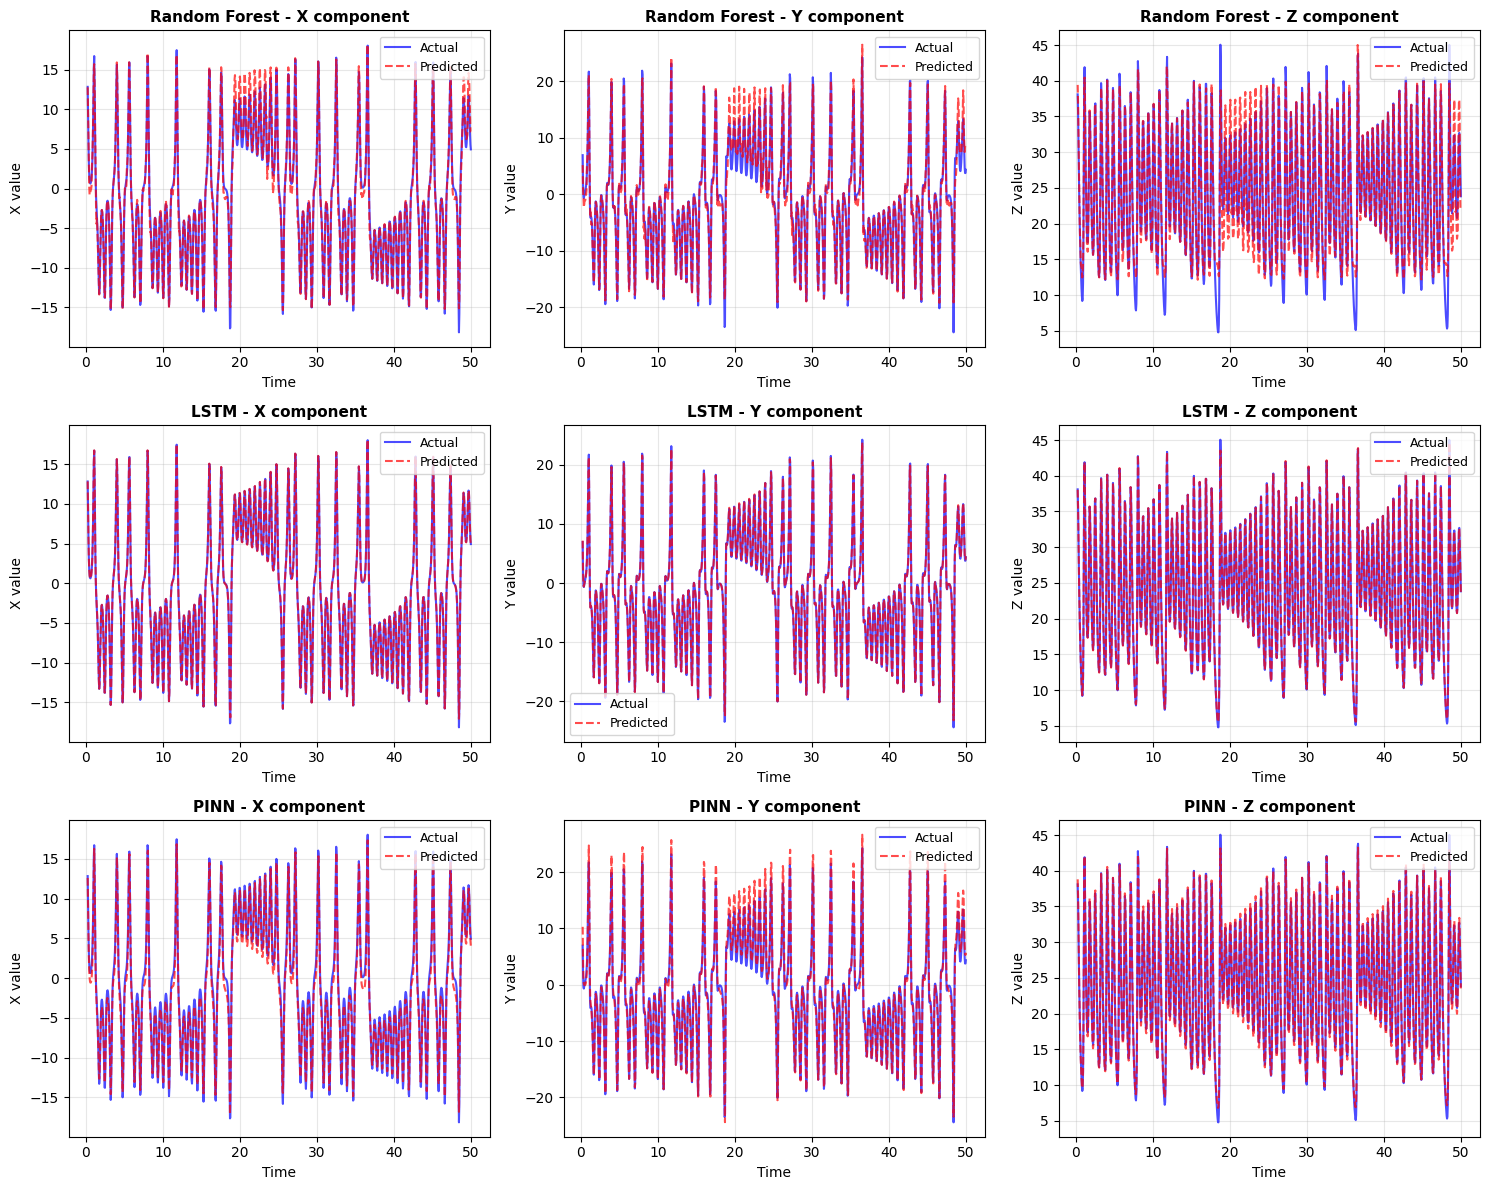

In [7]:
# ============================================================================
# 1. GENERATE LORENZ SYSTEM DATA
# ============================================================================

def lorenz(t, state, sigma=10.0, rho=28.0, beta=8.0/3.0):
    x, y, z = state
    return [sigma*(y-x), x*(rho-z)-y, x*y-beta*z]

# Training data: original trajectory
# We generate our training data using initial conditions [1, 1, 1]
# spanning 50 time units with 10,000 data points.
t_span, n_points = (0, 50), 10000
sol_train = solve_ivp(lorenz, t_span, [1.0, 1.0, 1.0], 
                      t_eval=np.linspace(*t_span, n_points), method='RK45')
t_train, trajectory_train = sol_train.t, sol_train.y.T

# Importantly, we generate a SEPARATE test trajectory with completely 
# different initial conditions [5, 10, 15]. This ensures we're testing true 
# generalization, not memorization."
sol_test = solve_ivp(lorenz, t_span, [5.0, 10.0, 15.0], 
                     t_eval=np.linspace(*t_span, n_points), method='RK45')
t_test_full, trajectory_test = sol_test.t, sol_test.y.T

print(f"Generated TRAINING trajectory: {len(t_train)} points, initial=[1.0, 1.0, 1.0]")
print(f"Generated TEST trajectory: {len(trajectory_test)} points, initial=[5.0, 10.0, 15.0]")

# ============================================================================
# 2. PREPARE DATA
# ============================================================================
# We split our training data into 30% for training and 70% for 
# validation. The test set comes entirely from our separate trajectory
n_train = int(0.3*len(trajectory_train))
train_data = trajectory_train[:n_train]
val_data = trajectory_train[n_train:]

# Test data: use the separate trajectory
test_data = trajectory_test

print(f"\nTraining samples: {len(train_data)}")
print(f"Validation samples: {len(val_data)}")
print(f"Test samples: {len(test_data)} (from separate trajectory)")

# Standardize : Converts to zero mean and unit variance
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train_data)
val_scaled = scaler.transform(val_data)
test_scaled = scaler.transform(test_data)

# Create sequences (use 50 timesteps to predict next state)
def create_sequences(data, seq_len=50):
    X = [data[i:i+seq_len] for i in range(len(data)-seq_len)]
    y = [data[i+seq_len] for i in range(len(data)-seq_len)]
    return np.array(X), np.array(y)

X_train, y_train = create_sequences(train_scaled)
X_val, y_val = create_sequences(val_scaled)
X_test, y_test = create_sequences(test_scaled)
print(f"Training sequences: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")

# ============================================================================
# 3. TRAIN MODELS
# ============================================================================

# Random Forest Regression
# Our first model is Random Forest
# It's a traditional ML approach that doesn't understand temporal dependencies
# but can capture complex non-linear relationships
print("\n[1/3] Training Random Forest Regression...")
from sklearn.ensemble import RandomForestRegressor
forest = RandomForestRegressor(n_estimators=10, random_state=42, n_jobs=-1)
forest.fit(X_train.reshape(len(X_train), -1), y_train)
forest_pred = forest.predict(X_test.reshape(len(X_test), -1))
forest_mse = mean_squared_error(y_test, forest_pred)

# LSTM (Long Short Term Memory)
# Our second model is an LSTM - a type of recurrent neural network.
# designed specifically for sequential data. It has memory cells that can 
# learn temporal dependencies and patterns over time.
print("[2/3] Training LSTM...")
lstm = keras.Sequential([
    layers.LSTM(64, input_shape=(50, 3)),
    layers.Dense(3)
])
lstm.compile(optimizer='adam', loss='mse')
lstm.fit(X_train, y_train, epochs=50, batch_size=32, 
         validation_data=(X_val, y_val), verbose=0)
lstm_pred = lstm.predict(X_test, verbose=0)
lstm_mse = mean_squared_error(y_test, lstm_pred)

# PINN (Physics-Informed Neural Network)
# Our third model is a PINN - it's unique because it incorporates 
# the actual Lorenz equations into the training process. This physics-informed
# approach constrains the network to respect the underlying physical laws."
print("[3/3] Training PINN...")
class PINN(keras.Model):
    def __init__(self):
        super().__init__()
        self.d1 = layers.Dense(32, activation='tanh')
        self.d2 = layers.Dense(32, activation='tanh')
        self.out = layers.Dense(3)
    
    def call(self, x):
        return self.out(self.d2(self.d1(x)))

pinn = PINN()
optimizer = keras.optimizers.Adam(0.001)
dt = t_train[1] - t_train[0] 

for epoch in range(50):
    for i in range(0, len(X_train), 32):
        batch_X, batch_y = X_train[i:i+32], y_train[i:i+32]
        state = batch_X[:, -1, :]
        
        with tf.GradientTape() as tape:
            pred = pinn(state, training=True)
            data_loss = tf.reduce_mean(tf.square(pred - batch_y))
            
            # Physics loss (Lorenz equations)
            x, y, z = state[:, 0], state[:, 1], state[:, 2]
            x_p, y_p, z_p = pred[:, 0], pred[:, 1], pred[:, 2]
            dx = (x_p - x)/dt - 10*(y - x)
            dy = (y_p - y)/dt - (x*(28 - z) - y)
            dz = (z_p - z)/dt - (x*y - 8/3*z)
            physics_loss = tf.reduce_mean(tf.square(dx) + tf.square(dy) + tf.square(dz))
            
            loss = data_loss + 0.1 * physics_loss
        
        grads = tape.gradient(loss, pinn.trainable_variables)
        optimizer.apply_gradients(zip(grads, pinn.trainable_variables))

pinn_pred = pinn(X_test[:, -1, :], training=False).numpy()
pinn_mse = mean_squared_error(y_test, pinn_pred)

# ============================================================================
# 4. RESULTS
# ============================================================================
print(f"\n{'='*60}")
print(f"RESULTS - Test Set MSE")
print(f"{'='*60}")
print(f"Random Forest:  {forest_mse:.6f}")
print(f"LSTM:              {lstm_mse:.6f}")
print(f"PINN:              {pinn_mse:.6f}")
print(f"{'='*60}\n")

# ============================================================================
# 5. VISUALIZATION
# ============================================================================
# Inverse transform predictions
y_test_orig = scaler.inverse_transform(y_test)
forest_pred_orig = scaler.inverse_transform(forest_pred)
lstm_pred_orig = scaler.inverse_transform(lstm_pred)
pinn_pred_orig = scaler.inverse_transform(pinn_pred)

# Get test time points (from the test trajectory)
t_test = t_test_full[50:50+len(y_test)]  

# Create interpolated smooth curves
t_interp = np.linspace(t_test[0], t_test[-1], 1000)

fig, axes = plt.subplots(3, 3, figsize=(15, 12))
models = [('Random Forest', forest_pred_orig), ('LSTM', lstm_pred_orig), ('PINN', pinn_pred_orig)]
coords = ['X', 'Y', 'Z']

for row, (model_name, pred) in enumerate(models):
    for col, coord in enumerate(coords):
        ax = axes[row, col]
        
        # Interpolate
        f_actual = interp1d(t_test, y_test_orig[:, col], kind='cubic')
        f_pred = interp1d(t_test, pred[:, col], kind='cubic')
        
        actual_interp = f_actual(t_interp)
        pred_interp = f_pred(t_interp)
        
        # Plot
        ax.plot(t_interp, actual_interp, 'b-', label='Actual', linewidth=1.5, alpha=0.7)
        ax.plot(t_interp, pred_interp, 'r--', label='Predicted', linewidth=1.5, alpha=0.7)
        
        ax.set_xlabel('Time', fontsize=10)
        ax.set_ylabel(f'{coord} value', fontsize=10)
        ax.set_title(f'{model_name} - {coord} component', fontsize=11, fontweight='bold')
        ax.legend(fontsize=9)
        ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
